# Use Elibitility Trace Actor-Critic to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

14:32:46 [INFO] env: <AcrobotEnv<Acrobot-v1>>
14:32:46 [INFO] action_space: Discrete(3)
14:32:46 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
14:32:46 [INFO] reward_range: (-inf, inf)
14:32:46 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
14:32:46 [INFO] _max_episode_steps: 500
14:32:46 [INFO] _elapsed_steps: None
14:32:46 [INFO] id: Acrobot-v1
14:32:46 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
14:32:46 [INFO] reward_threshold: -100.0
14:32:46 [INFO] nondeterministic: False
14:32:46 [INFO] max_episode_steps: 500
14:32:46 [INFO] _kwargs: {}
14:32:46 [INFO] _env_name: Acrobot


In [3]:
class ElibilityTraceActorCriticAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.actor_lambda = 0.9
        self.critic_lambda = 0.9

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax,
                loss=losses.categorical_crossentropy, learning_rate=0.0001)
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                learning_rate=0.0002)

    def build_net(self, input_size, hidden_sizes, output_size=1,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape': (input_size,)} if layer == 0 else {}
            model.add(layers.Dense(units=hidden_size, activation=activation,
                    **kwargs))
        model.add(layers.Dense(units=output_size, activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.
            self.actor_trace_tensors = [0. * weight for weight in
                    self.actor_net.get_weights()]
            self.critic_trace_tensors = [0. * weight for weight in
                    self.critic_net.get_weights()]

    def step(self, observation, reward, terminated):
        probs = self.actor_net.predict(observation[np.newaxis], verbose=0)[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, terminated, _ = \
                self.trajectory[-8:]
        states = state[np.newaxis]
        q = self.critic_net.predict(states, verbose=0)[0, 0]
        next_v = self.critic_net.predict(next_state[np.newaxis], verbose=0)[0, 0]
        target = reward + (1. - terminated) * self.gamma * next_v
        td_error = target - q

        # update actor
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(state_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1.))
        grad_tensors = tape.gradient(logpi_tensor, self.actor_net.variables)
        self.actor_trace_tensors = [self.gamma * self.actor_lambda * trace +
                self.discount * grad for trace, grad in
                zip(self.actor_trace_tensors, grad_tensors)]
        actor_grads = [-td_error * trace for trace in self.actor_trace_tensors]
        actor_grads_and_vars = tuple(zip(actor_grads, self.actor_net.variables))
        self.actor_net.optimizer.apply_gradients(actor_grads_and_vars)

        # update critic
        with tf.GradientTape() as tape:
            v_tensor = self.critic_net(state_tensor)[0, 0]
        grad_tensors = tape.gradient(v_tensor, self.critic_net.variables)
        self.critic_trace_tensors = [self.gamma * self.critic_lambda * trace +
                grad for trace, grad in
                zip(self.critic_trace_tensors, grad_tensors)]
        critic_grads = [-td_error * trace for trace in self.critic_trace_tensors]
        critic_grads_and_vars = tuple(zip(critic_grads,
                self.critic_net.variables))
        self.critic_net.optimizer.apply_gradients(critic_grads_and_vars)


agent = ElibilityTraceActorCriticAgent(env)

14:32:48 [INFO] ==== train ====
14:34:49 [INFO] train episode 0: reward = -481.00, steps = 482
14:36:50 [INFO] train episode 1: reward = -500.00, steps = 500
14:38:55 [INFO] train episode 2: reward = -500.00, steps = 500
14:40:59 [INFO] train episode 3: reward = -500.00, steps = 500
14:43:03 [INFO] train episode 4: reward = -500.00, steps = 500
14:45:10 [INFO] train episode 5: reward = -500.00, steps = 500
14:47:00 [INFO] train episode 6: reward = -427.00, steps = 428
14:49:05 [INFO] train episode 7: reward = -500.00, steps = 500
14:50:53 [INFO] train episode 8: reward = -438.00, steps = 439
14:52:59 [INFO] train episode 9: reward = -500.00, steps = 500
14:54:56 [INFO] train episode 10: reward = -482.00, steps = 483
14:57:02 [INFO] train episode 11: reward = -500.00, steps = 500
14:59:07 [INFO] train episode 12: reward = -500.00, steps = 500
15:00:59 [INFO] train episode 13: reward = -459.00, steps = 460
15:03:00 [INFO] train episode 14: reward = -500.00, steps = 500
15:05:04 [INFO] tr

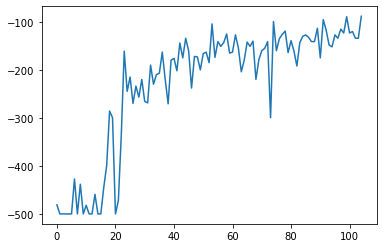

In [4]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()